### Métricas de clasificación

Reutilizamos el cuaderno anterior.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv('Data.csv')

df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(0)

df.columns = df.columns.str.lower().str.replace(' ', '_')

cadena_columnas = list(df.dtypes[df.dtypes == 'object'].index)

for col in cadena_columnas:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.churn = (df.churn == 'yes').astype(int)

Modelo completo

In [ ]:
df_train_completo, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_completo, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

In [ ]:
categoricas = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection',
               'techsupport', 'streamingtv', 'streamingmovies',
               'contract', 'paperlessbilling', 'paymentmethod']
numericas = ['tenure', 'monthlycharges', 'totalcharges']


In [ ]:
train_dict = df_train[categoricas + numericas].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

modeloRL = LogisticRegression(solver='liblinear', random_state=1)
modeloRL.fit(X_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [ ]:
val_dict = df_val[categoricas + numericas].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred= modeloRL.predict_proba(X_val)[:, 1]

Un modelo más pequeño para desarrollar.

In [ ]:
subconjunto = ['contract', 'tenure', 'totalcharges']
train_dict_sub = df_train[subconjunto].to_dict(orient='records')
dv_sub = DictVectorizer(sparse=False)
dv_sub.fit(train_dict_sub)

X_sub_train = dv_sub.transform(train_dict_sub)

submodeloRL = LogisticRegression(solver='liblinear', random_state=1)
submodeloRL.fit(X_sub_train, y_train)

LogisticRegression(random_state=1, solver='liblinear')

In [ ]:
sub_val_dict = df_val[subconjunto].to_dict(orient='records')
X_sub_val = dv_sub.transform(sub_val_dict)

sub_y_pred = submodeloRL.predict_proba(X_sub_val)[:, 1]

#### Exactitud

Exactitud para el modelo completo.

In [ ]:
y_pred = modeloRL.predict_proba(X_val)[:, 1]
churn = y_pred >= 0.5
(churn == y_val).mean()

0.8016129032258065

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(y_val, y_pred >= 0.5)

0.8016129032258065

Exactitud para el modelo más pequeño

In [ ]:
#val_dict_sub = df_val[subconjunto].to_dict(orient='records')
#X_sub_val = dv_sub.transform(val_dict_sub)
#sub_y_pred= submodeloRL.predict_proba(X_sub_val)[:, 1]
#sub_churn = sub_y_pred >= 0.5
#accuracy_score(y_val, sub_churn)

In [ ]:
umbrales = np.linspace(0, 1, 11)
umbrales

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
umbrales = np.linspace(0, 1, 21)

exactitudes = []

for t in umbrales:
    acc = accuracy_score(y_val, y_pred >= t)
    exactitudes.append(acc)
    print('%0.2f %0.3f' % (t, acc))

Repetimos el mismo proceso anterior, pero en ugar de solo de imprimi los puntajes de exactitud, primero colocamos los

In [ ]:
umbrales=np.linspace(0,1,11)
for t in umbrales:
  churn=y_pred>=t
  acc=accuracy_score(y_val, churn)
  print('%0.2f  %0.3f' % (t, acc))

0.00  0.261
0.10  0.595
0.20  0.690
0.30  0.755
0.40  0.782
0.50  0.802
0.60  0.790
0.70  0.774
0.80  0.742
0.90  0.739
1.00  0.739


In [ ]:
umbrales = np.linspace(0, 1, 11)

exactitudes = []

for t in umbrales:
    acc = accuracy_score(y_val, y_pred >= t)
    exactitudes.append(acc)
    print('%0.2f %0.3f' % (t, acc))

0.00 0.261
0.10 0.595
0.20 0.690
0.30 0.755
0.40 0.782
0.50 0.802
0.60 0.790
0.70 0.774
0.80 0.742
0.90 0.739
1.00 0.739


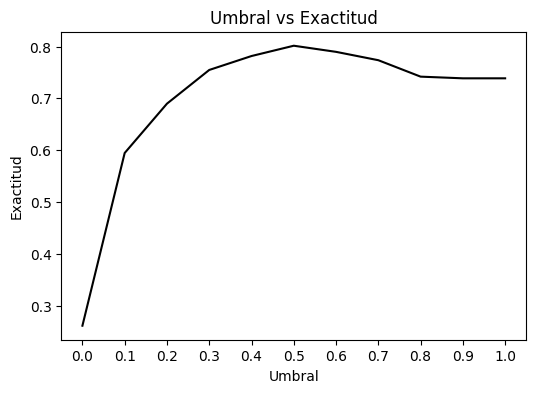

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(umbrales,exactitudes, color='black')

plt.title('Umbral vs Exactitud')
plt.xlabel('Umbral')
plt.ylabel('Exactitud')

plt.xticks(np.linspace(0, 1, 11))

plt.show()

In [ ]:
sub_churn = sub_y_pred >= 0.5
(sub_churn == y_val).mean()

0.7672043010752688

In [ ]:
accuracy_score(y_val, sub_churn)

0.7672043010752688

Exactitud para un baseline inicial

In [ ]:
size_val = len(y_val)
baseline = np.repeat(False, size_val)
baseline

array([False, False, False, ..., False, False, False])

Ahora podemos verificar la exactitud de esta predicción del baseline usando el mismo código que usamos anteriormente:


In [ ]:
accuracy_score(baseline, y_val)

#### Tabla de confusión

In [ ]:
verdadero_positivo = ((y_pred >= 0.5) & (y_val == 1)).sum()
falso_positivo = ((y_pred >= 0.5) & (y_val == 0)).sum()
falso_negativo = ((y_pred < 0.5) & (y_val == 1)).sum()
verdadero_negativo = ((y_pred < 0.5) & (y_val == 0)).sum()

In [ ]:
tabla_confusion = np.array(
     # predict neg    pos
    [[verdadero_negativo, falso_positivo], # actual neg
     [falso_negativo, verdadero_positivo]]) # actual pos

tabla_confusion

array([[1202,  172],
       [ 197,  289]])

La tabla de confusión muestra el número de verdaderos positivos (TP), verdaderos negativos (TN), falsos positivos (FP) y falsos negativos

---

(FN) que el modelo ha predicho. En tu ejemplo, la tabla de confusión se ve así:

---


        **Predicción Negativa	Predicción Positiva**
**Negativo Verdadero	1202           	172**
**Positivo Verdadero	197	            289**


---

Esto significa que el modelo ha predicho correctamente 1202 verdaderos negativos y 289 verdaderos positivos. Sin embargo, también ha predicho incorrectamente 172 falsos positivos y 197 falsos negativos.

La exactitud es una medida de rendimiento que se calcula como el número total de predicciones correctas dividido por el número total de predicciones. En el caso de una tabla de confusión binaria, se calcula como (verdaderos positivos + verdaderos negativos) / (verdaderos positivos + verdaderos negativos + falsos positivos + falsos negativos).

En tu ejemplo, la exactitud sería (1202 + 289) / (1202 + 289 + 172 + 197) = 0.819, o aproximadamente el 81.9%.

In [ ]:
tabla_confusion / tabla_confusion.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

Tabla de confusión para el submodelo propuesto.

In [ ]:
verdadero_positivo = ((sub_y_pred >= 0.5) & (y_val == 1)).sum()
falso_positivo = ((sub_y_pred >= 0.5) & (y_val == 0)).sum()
falso_negativo = ((sub_y_pred < 0.5) & (y_val == 1)).sum()
verdadero_negativo = ((sub_y_pred < 0.5) & (y_val == 0)).sum()

In [ ]:
precision = verdadero_positivo / (verdadero_positivo + falso_positivo)
exhaustividad = verdadero_positivo / (verdadero_positivo + falso_negativo)
precision, exhaustividad

(0.5626477541371159, 0.4897119341563786)

In [ ]:
 #tabla_confusion = np.array(
     # predict neg    pos
   #  [[verdadero_negativo, falso_positivo], # actual neg
   #   [falso_negativo, verdadero_positivo]]) # actual pos

 #tabla_confusion

array([[1189,  185],
       [ 248,  238]])

In [ ]:
 #tabla_confusion / tabla_confusion.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

#### Precisión y exhaustividad

In [ ]:
precision = verdadero_positivo / (verdadero_positivo + falso_positivo)
exhaustividad =  verdadero_positivo / (verdadero_positivo + falso_negativo)
precision, exhaustividad

(0.5626477541371159, 0.4897119341563786)

In [ ]:
tabla_confusion / tabla_confusion.sum()

array([[0.63924731, 0.09946237],
       [0.13333333, 0.12795699]])

In [ ]:
precision = verdadero_positivo / (verdadero_positivo + falso_positivo)
exhaustividad = verdadero_positivo / (verdadero_positivo + falso_negativo)
precision, exhaustividad

(0.5626477541371159, 0.4897119341563786)

#### ROC y AUC

TPR y FPR

In [ ]:
puntuaciones = []

umbrales = np.linspace(0, 1, 101)

for t in umbrales: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    puntuaciones.append((t, tp, fp, fn, tn))

df_puntuaciones = pd.DataFrame(puntuaciones)
df_puntuaciones.columns = ['umbral', 'tp', 'fp', 'fn', 'tn']

In [ ]:
df_puntuaciones[::10]

,umbral,tp,fp,fn,tn
0,0.0,486,1374,0,0
10,0.1,458,726,28,648
20,0.2,421,512,65,862
30,0.3,380,350,106,1024
40,0.4,337,257,149,1117
50,0.5,289,172,197,1202
60,0.6,200,105,286,1269
70,0.7,99,34,387,1340
80,0.8,7,1,479,1373
90,0.9,0,0,486,1374


In [ ]:
df_puntuaciones['tpr'] = df_puntuaciones.tp / (df_puntuaciones.tp + df_puntuaciones.fn)
df_puntuaciones['fpr'] = df_puntuaciones.fp / (df_puntuaciones.fp + df_puntuaciones.tn)

In [ ]:
df_puntuaciones[::10]

,umbral,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,458,726,28,648,0.942387,0.528384
20,0.2,421,512,65,862,0.866255,0.372635
30,0.3,380,350,106,1024,0.781893,0.254731
40,0.4,337,257,149,1117,0.693416,0.187045
50,0.5,289,172,197,1202,0.594650,0.125182
60,0.6,200,105,286,1269,0.411523,0.076419
70,0.7,99,34,387,1340,0.203704,0.024745
80,0.8,7,1,479,1373,0.014403,0.000728
90,0.9,0,0,486,1374,0.000000,0.000000


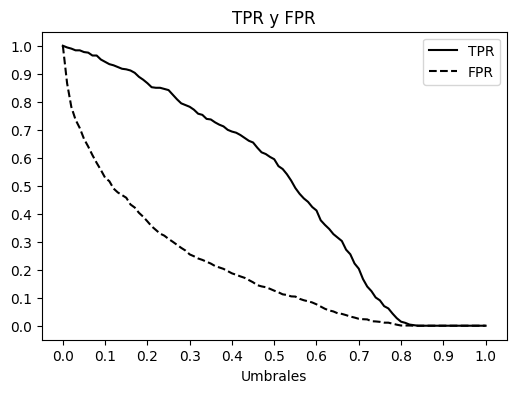

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(df_puntuaciones.umbral, df_puntuaciones.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_puntuaciones.umbral, df_puntuaciones.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Umbrales')
plt.title('TPR y FPR')

plt.show()

#### Baseline aleatorio

In [ ]:
def dataframe_tpr_fpr(y_val, y_pred):
    puntuaciones = []

    umbrales = np.linspace(0, 1, 101)

    for t in umbrales:
        tp = ((y_pred >= t) & (y_val == 1)).sum()
        fp = ((y_pred >= t) & (y_val == 0)).sum()
        fn = ((y_pred < t) & (y_val == 1)).sum()
        tn = ((y_pred < t) & (y_val == 0)).sum()

        puntuaciones.append((t, tp, fp, fn, tn))

    df_puntuaciones = pd.DataFrame(puntuaciones)
    df_puntuaciones.columns = ['umbral', 'tp', 'fp', 'fn', 'tn']

    df_puntuaciones['tpr'] = df_puntuaciones.tp / (df_puntuaciones.tp + df_puntuaciones.fn)
    df_puntuaciones['fpr'] = df_puntuaciones.fp / (df_puntuaciones.fp + df_puntuaciones.tn)

    return df_puntuaciones

In [ ]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))
df_rand = dataframe_tpr_fpr(y_val, y_rand)
df_rand[::10]

,umbral,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,440,1236,46,138,0.905350,0.899563
20,0.2,392,1101,94,273,0.806584,0.801310
30,0.3,339,972,147,402,0.697531,0.707424
40,0.4,288,849,198,525,0.592593,0.617904
50,0.5,239,723,247,651,0.491770,0.526201
60,0.6,193,579,293,795,0.397119,0.421397
70,0.7,152,422,334,952,0.312757,0.307132
80,0.8,98,302,388,1072,0.201646,0.219796
90,0.9,57,147,429,1227,0.117284,0.106987


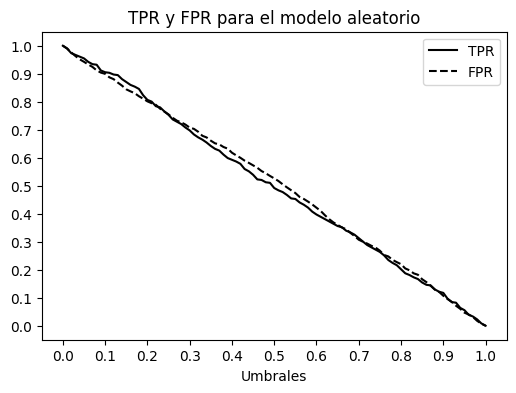

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(df_rand.umbral, df_rand.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_rand.umbral, df_rand.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.xlabel('Umbrales')
plt.title('TPR y FPR para el modelo aleatorio')

plt.show()

#### Baseline ideal

In [ ]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()

y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_pred_ideal = np.linspace(0, 1, num_neg + num_pos)

df_ideal = dataframe_tpr_fpr(y_ideal, y_pred_ideal)
df_ideal[::10]

,umbral,tp,fp,fn,tn,tpr,fpr
0,0.0,486,1374,0,0,1.000000,1.000000
10,0.1,486,1188,0,186,1.000000,0.864629
20,0.2,486,1002,0,372,1.000000,0.729258
30,0.3,486,816,0,558,1.000000,0.593886
40,0.4,486,630,0,744,1.000000,0.458515
50,0.5,486,444,0,930,1.000000,0.323144
60,0.6,486,258,0,1116,1.000000,0.187773
70,0.7,486,72,0,1302,1.000000,0.052402
80,0.8,372,0,114,1374,0.765432,0.000000
90,0.9,186,0,300,1374,0.382716,0.000000


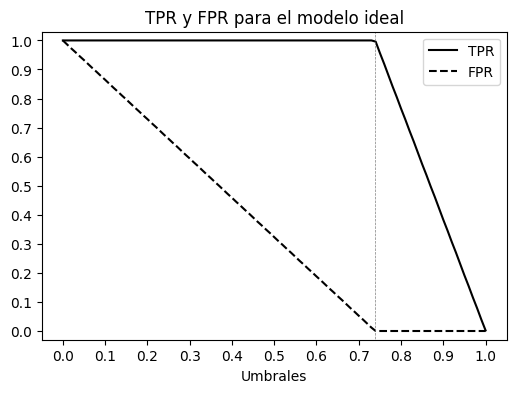

In [ ]:
plt.figure(figsize=(6, 4))

plt.plot(df_ideal.umbral, df_ideal.tpr, color='black', linestyle='solid', label='TPR')
plt.plot(df_ideal.umbral, df_ideal.fpr, color='black', linestyle='dashed', label='FPR')
plt.legend()

plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))

plt.vlines(1 - y_val.mean(), -1, 2, linewidth=0.5, linestyle='dashed', color='grey')
plt.ylim(-0.03, 1.03)

plt.xlabel('Umbrales')
plt.title('TPR y FPR para el modelo ideal')

plt.show()

#### Curva ROC

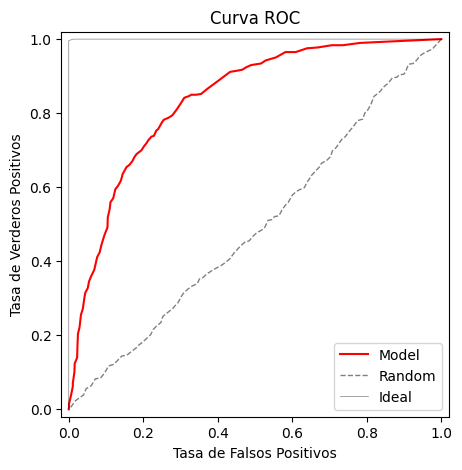

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(df_puntuaciones.fpr, df_puntuaciones.tpr, color='red', label='Model')
plt.plot(df_rand.fpr, df_rand.tpr, color='black', lw=1,
         linestyle='dashed', alpha=0.5, label='Random')
plt.plot(df_ideal.fpr, df_ideal.tpr, color='black', lw=0.5,
         linestyle='solid', alpha=0.5, label='Ideal')

plt.legend()

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verderos Positivos')

plt.title('Curva ROC')


plt.show()

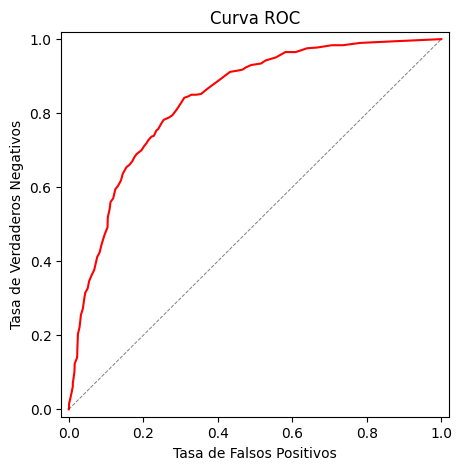

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(df_puntuaciones.fpr, df_puntuaciones.tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Negativos')

plt.title('Curva ROC')

plt.show()

### Usando Scikit-Learn para dibujar la curva ROC

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [ ]:
fpr, tpr, umbrales = roc_curve(y_val, y_pred)

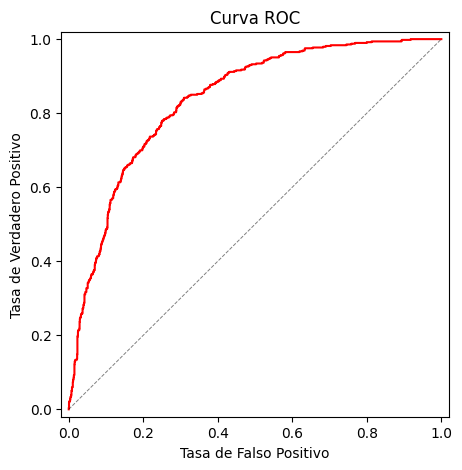

In [ ]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='red')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Tasa de Falso Positivo')
plt.ylabel('Tasa de Verdadero Positivo')

plt.title('Curva ROC')

plt.show()

#### AUC: Area bajo la curva ROC

In [ ]:
df_sub_puntuaciones = dataframe_tpr_fpr(y_val, sub_y_pred)

In [ ]:
auc(df_puntuaciones.fpr, df_puntuaciones.tpr)

0.8359001084215382

In [ ]:
auc(df_sub_puntuaciones.fpr, df_sub_puntuaciones.tpr)

0.8125475467380692

Comparando múltiples modelos con curvas ROC

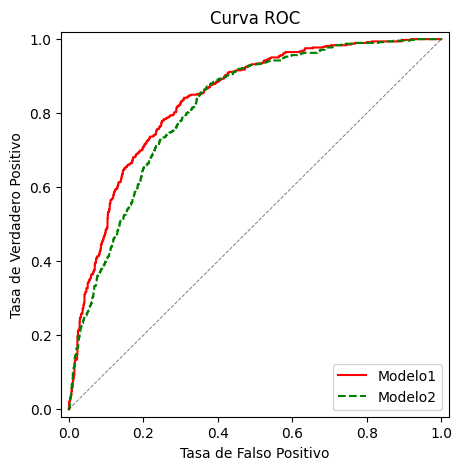

In [ ]:
fpr_modelo1, tpr_modelo1, _ = roc_curve(y_val, y_pred)
fpr_modelo2, tpr_modelo2, _ = roc_curve(y_val, sub_y_pred)

plt.figure(figsize=(5, 5))

plt.plot(fpr_modelo1, tpr_modelo1, color='red', linestyle='solid', label='Modelo1')
plt.plot(fpr_modelo2, tpr_modelo2, color='green', linestyle='dashed', label='Modelo2')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('Tasa de Falso Positivo')
plt.ylabel('Tasa de Verdadero Positivo')

plt.title('Curva ROC')
plt.legend(loc='lower right')

plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
roc_auc_score(y_val, y_pred)

0.8363366398907399

In [ ]:
roc_auc_score(y_val, sub_y_pred)

0.8129354083179088

#### Interpretación de AUC

La probabilidad de que un ejemplo positivo elegido al azar tenga una clasificación más alta que un ejemplo negativo elegido al azar.

In [ ]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

np.random.seed(1)
neg_1 = np.random.randint(low=0, high=len(neg), size=10000)
pos_1 = np.random.randint(low=0, high=len(pos), size=10000)
(pos[pos_1] > neg[neg_1]).mean()


### Validación cruzada

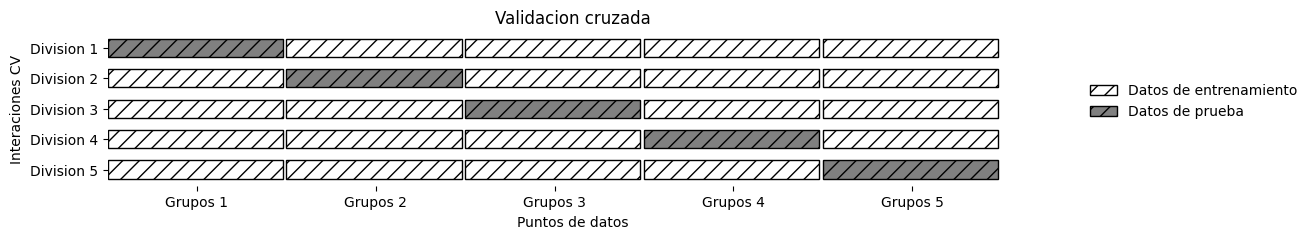

In [ ]:
from utilidades import *
dibuja_validacion_cruzada()

Entrenamiento del modelo.

In [ ]:
def entrenamiento(df, y):
    cat = df[categoricas + numericas].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    modelRL = LogisticRegression(solver='liblinear')
    modelRL.fit(X, y)

    return dv, modelRL

Aplicación del modelo a nuevos datos.

In [ ]:
def predict(df, dv, modelo):
    cat = df[categoricas+ numericas].to_dict(orient='records')
    X = dv.transform(cat)

    y_pred = modelo.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
from sklearn.model_selection import KFold

Ten en cuenta que al definir la división en la clase KFold, establecemos tres parámetros:

* `n_splits = 10`: eso es K, que especifica el número de divisiones.
* `shuffle = True`: pedimos que se mezcle los datos antes de dividirlos.
* `random_state = 1`: debido a que hay aleatorización en el proceso (reorganización de datos), queremos que los resultados sean reproducibles, por lo que arreglamos la semilla para el generador de números aleatorios.


In [ ]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [ ]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_completo):
    df_train = df_train_completo.iloc[train_idx]
    y_train = df_train.churn.values

    df_val = df_train_completo.iloc[val_idx]
    y_val = df_val.churn.values

    dv, modelo = entrenamiento(df_train, y_train)
    y_pred = predict(df_val, dv, modelo)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [ ]:
np.array(aucs).round(3)

array([0.849, 0.841, 0.859, 0.833, 0.824, 0.842, 0.844, 0.822, 0.845,
       0.861])

Podemos obtener algunas estadísticas de esta distribución, como la media y la desviación estándar:

In [ ]:
print('auc = %0.3f ± %0.3f' % (np.mean(aucs), np.std(aucs)))

#### Busquemos los mejores parámetros

Seeleccionamos el mejor parámetro C.

In [ ]:
def entrenamiento(df, y, C=1.0):
    cat = df[categoricas + numericas].to_dict(orient='records')
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    modelRL = LogisticRegression(solver='liblinear')
    modelRL.fit(X, y)

    return dv, modelRL

Afinando el modelo: seleccionando el mejor parámetro C usando validación cruzada

In [ ]:
nfolds = 5
kfold = KFold(n_splits=nfolds, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 10]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_completo):
        df_train = df_train_completo.iloc[train_idx]
        df_val = df_train_completo.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, modelo = entrenamiento(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, modelo)

        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=0.001, auc = 0.841 ± 0.007
C=0.01, auc = 0.841 ± 0.007
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


Ahora entrenamos el modelo en todos los conjuntos de datos de entrenamiento y validación y aplicarlo al conjunto de datos de prueba para verificar que realmente funciona bien.


In [ ]:
y_train = df_train_completo.churn.values
y_test = df_test.churn.values

dv, modelo = entrenamiento(df_train_completo, y_train, C=0.5)
y_pred = predict(df_test, dv, modelo)

auc = roc_auc_score(y_test, y_pred)
print('auc = %.3f' % auc)

auc = 0.858


### Ejercicio

1. En este cuaderno, dibujamos el TPR y FPR para diferentes valores de un umbral, que ayudan a comprender qué significan estas métricas y también cómo cambia el rendimiento del modelo cuando elegimos un umbral diferente. Es útil hacer un ejercicio similar para la precisión y la exhaustividad, así que intenta repetir este experimento, esta vez usando  la precisión y la exhaustividad en lugar de TPR y FPR.


In [ ]:
## Tu respuesta

2. Al dibujar la precisión y la exhaustividad para diferentes valores de umbral, podemos ver que existe un conflicto entre  la precisión y la exhaustividad: cuando una sube, la otra baja y viceversa. Esto se denomina `compensación de  la precisión y la exhaustividad`: no podemos seleccionar un umbral que haga que tanto la precisión como la exhaustividad sean buenas. Sin embargo, tenemos estrategias para seleccionar el umbral, aunque la precisión y exahustividad están en conflicto. Uno de ellos es dibujar curvas de precisión y exahustividad y ver dónde se cruzan, y usar este umbral para binarizar las predicciones. Intenta implementar esta idea.


In [ ]:
### Tu respuesta

3. Otra idea para evitar el equilibrio entre  la precisión y la exhaustividad es la puntuación F1, una puntuación que combina la  precisión y la exhaustividad en un solo valor. Luego, para seleccionar el mejor umbral, simplemente podemos elegir el que maximiza la puntuación F1. La fórmula para calcular la puntuación F1 es:  $F1 = 2\cdot P\cdot R / (P + R)$, donde $P$ es la precisión  y $R$ es la exahustividad. Implementa esta idea y selecciona el mejor umbral según la métrica F1.



In [ ]:
## Tu respuesta

4. Cubrimos la validación cruzada de K-fold y la usamos para comprender cómo podría verse la distribución de las puntuaciones de AUC en un conjunto de datos de prueba. Cuando $K = 10$, obtenemos 10 observaciones, que en algunas circunstancias pueden no ser suficientes. Sin embargo, la idea se puede extender a pasos repetidos de validación cruzada de K-fold. El proceso es simple: repetimos el proceso de validación cruzada de K-fold varias veces, cada vez que mezclamos el conjunto de datos de manera diferente seleccionando una semilla aleatoria diferente en cada iteración. Implementa una validación cruzada repetida y realice una validación cruzada de 10 -fold 10 veces para ver cómo se ve la distribución de las puntuaciones.

In [ ]:
## Tu respuesta

5. Utiliza el proyecto de puntuación de clientes potenciales y el proyecto de predicción predeterminada. Prueba lo siguiente:

 - Calcula todas las métricas que cubrimos en este cuaderno: la tabla de confusión, exactitud y recuperación, y AUC. También trata de calcular los puntajes de los ejercicios: el puntaje F1 así como el AU PR (el área bajo la curva de recuperación de exactitud).
 - Utiliza la validación cruzada K-fold para seleccionar el mejor parámetro C para el modelo.


In [ ]:
## Tu respuesta